## Analysis on the new commision system

In [1]:
### Testing the significance of new commision strategy
import pandas as pd
import numpy as np
import datetime as dt
import pyodbc

import matplotlib.pyplot as plt
import seaborn as sns

con=pyodbc.connect('Driver={SQL Server};Server=pelsvr44;Database=protobase;uid=DAMUT;pwd=Makatet@2019')

In [2]:
df=pd.read_sql_query('''
select max(r.territory)Territory, max( m.DriverID)DriverId ,max(RName) Route,m.OutletID as CustomerId,max(CustomerName)CustomerName,
 max(cast(TransTime as date)) Date,  sum(refill6kg)refill6kg,sum(refill13kg)Refill_13kg,sum(refill50kg)refill50kg,
 sum(outright6kg)Outright_6kg,sum(outright13k)outright_13kg,sum(outright50k)outright50k,
 sum(refill13kg+outright6kg+outright13k+refill6kg+outright50k+refill50kg)Sales
from tblMasterSales m 
inner join(
select SaleID, max(date_added)date_added,
 sum(case when ProductDesc ='6KG Refill'then Quantity else 0 end) refill6kg,
sum (case when ProductDesc ='13KG Refill'then Quantity else 0 end) refill13kg,
sum (case when ProductDesc ='6KG Outright'then Quantity else 0 end) outright6kg,
sum (case when ProductDesc ='13KG Outright'then Quantity else 0 end) outright13k,
sum (case when ProductDesc ='50KG Refill'then Quantity else 0 end) refill50kg,
sum (case when ProductDesc ='50KG Outright'then Quantity else 0 end) outright50k
 from tblSoldProducts  group by SaleID)s on m.SaleID=s.SaleID inner join tbl_routes r on r.route_id=m.RouteID
where m.date_added between '2019-01-01' and '2019-09-11' and OutletID not in (10602,19965,
20003)
group by OutletID,cast(m.date_added as date)
order by date desc
''',con)


In [3]:
df['Date']=pd.to_datetime(df['Date'])

In [4]:
df.head()

,Territory,DriverId,Route,CustomerId,CustomerName,Date,refill6kg,Refill_13kg,refill50kg,Outright_6kg,outright_13kg,outright50k,Sales
0,Nairobi North,13679,WITEITHIE,10115,KAMALIS,2019-09-10,9,3,0,0,0,0,12
1,Nairobi North,13656,ZIMMERMAN,10152,FLAMANAS,2019-09-10,4,1,0,0,0,0,5
2,Nairobi North,13679,WITEITHIE,10195,NGOI SUPERMARKET,2019-09-10,8,3,0,0,0,0,11
3,Nairobi South,8579,EASTLEIGH,1023,DESTINY GAS DEPOT AND SUPPLIERS,2019-09-10,5,0,0,0,0,0,5
4,Nairobi North,3520,ZIMMERMAN,10242,PASODA GAS,2019-09-10,5,0,0,0,0,0,5


In [5]:
df['PurchMonth']=df.Date.apply(lambda x: 
    x.strftime('%Y-%m'))

df.set_index('CustomerId',inplace=True)
    
df['CohortGroup']=df.groupby(level=0)['Date'].min().apply(
        lambda x: x.strftime('%Y-%m'))
df.reset_index(inplace=True)

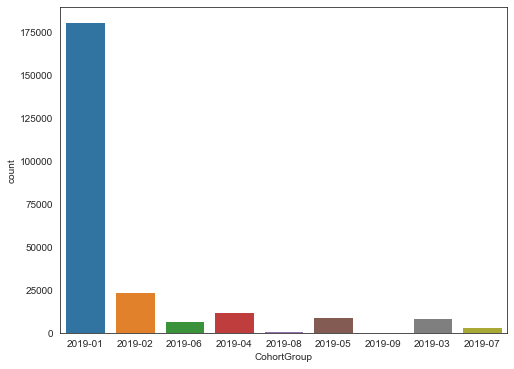

In [6]:
sns.set_style('white')
plt.figure(figsize=(8,6))
sns.countplot(x='CohortGroup',data=df)

In [7]:
Aug_cast=df.query('PurchMonth=="2019-08"')
Sep_cust=df.query('PurchMonth=="2019-09"')
Sep_cust.head()

,CustomerId,Territory,DriverId,Route,CustomerName,Date,refill6kg,Refill_13kg,refill50kg,Outright_6kg,outright_13kg,outright50k,Sales,PurchMonth,CohortGroup
0,10115,Nairobi North,13679,WITEITHIE,KAMALIS,2019-09-10,9,3,0,0,0,0,12,2019-09,2019-01
1,10152,Nairobi North,13656,ZIMMERMAN,FLAMANAS,2019-09-10,4,1,0,0,0,0,5,2019-09,2019-01
2,10195,Nairobi North,13679,WITEITHIE,NGOI SUPERMARKET,2019-09-10,8,3,0,0,0,0,11,2019-09,2019-01
3,1023,Nairobi South,8579,EASTLEIGH,DESTINY GAS DEPOT AND SUPPLIERS,2019-09-10,5,0,0,0,0,0,5,2019-09,2019-01
4,10242,Nairobi North,3520,ZIMMERMAN,PASODA GAS,2019-09-10,5,0,0,0,0,0,5,2019-09,2019-01


In [11]:
df_driver=df.groupby(['DriverId','Date'])['Sales'].sum().reset_index()
df_driver.head()

,DriverId,Date,Sales
0,2367,2019-01-02,219
1,2367,2019-01-03,75
2,2367,2019-01-04,159
3,2367,2019-01-05,108
4,2367,2019-01-07,108


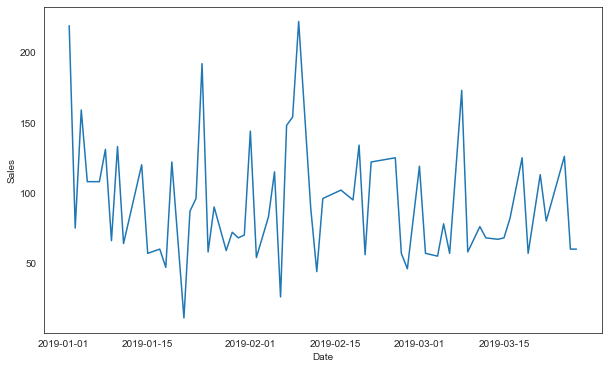

In [18]:
plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='Sales',data=df_driver.query('DriverId==2367'))

In [22]:
df.groupby(['DriverId','Date']).sum().head().reset_index()

,DriverId,Date,refill6kg,Refill_13kg,refill50kg,Outright_6kg,outright_13kg,outright50k,Sales
0,2367,2019-01-02,150,19,0,32,18,0,219
1,2367,2019-01-03,40,19,0,15,1,0,75
2,2367,2019-01-04,116,17,0,23,3,0,159
3,2367,2019-01-05,86,12,0,10,0,0,108
4,2367,2019-01-07,91,12,0,5,0,0,108
